In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification 
from sklearn.metrics import accuracy_score

import pickle

In [52]:
#X,y -> raw, target-> y, drop species 
# split into training and testing (test size=0.2)
# train the model with Logistic Regression log_model
#create Y_pred with predicted values 
#check accuracy score

Dataset size after preprocessing: (8000, 6)
Accuracy: 0.773125

Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      1230
           1       0.68      0.04      0.07       370

    accuracy                           0.77      1600
   macro avg       0.73      0.52      0.47      1600
weighted avg       0.75      0.77      0.68      1600



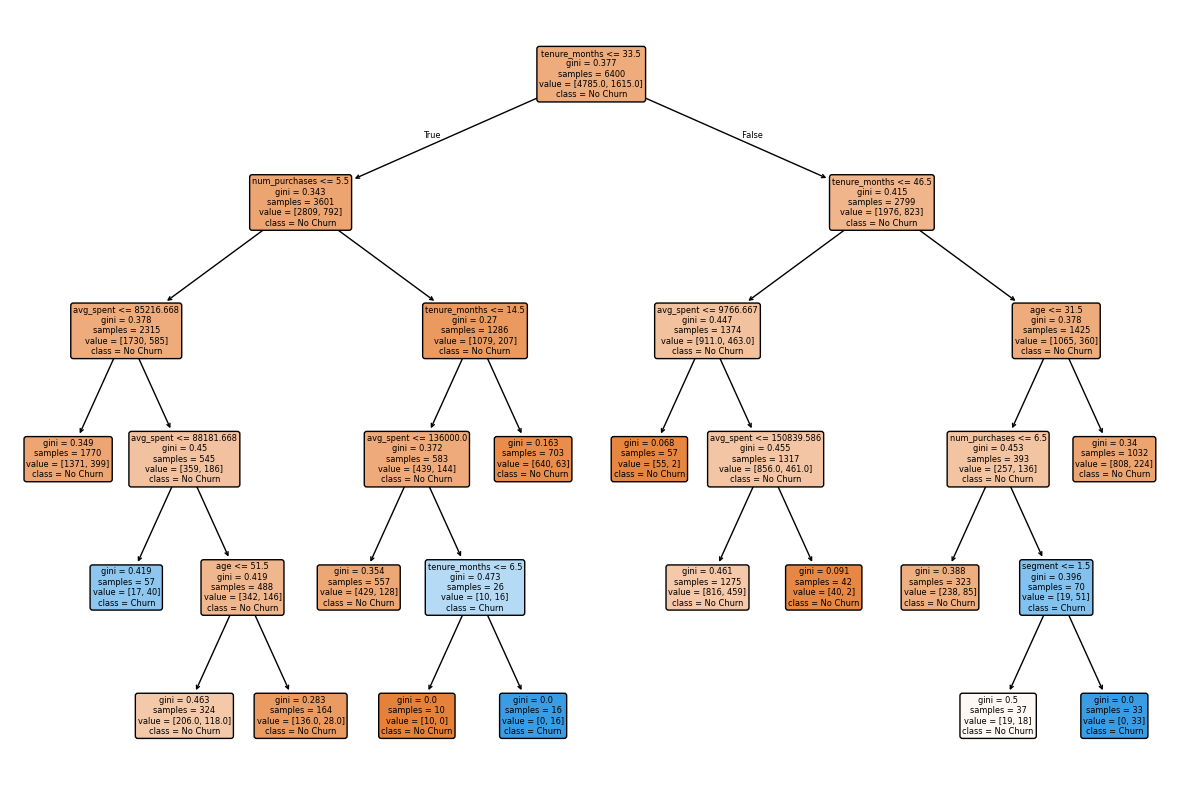

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../data/customer_intelligence_dataset.csv")

# Encode categorical features
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Encode segment using LabelEncoder
le = LabelEncoder()
df['segment'] = df['segment'].astype(str)  # ensure string
df['segment'] = le.fit_transform(df['segment'])

# Ensure churn is numeric
df['churn'] = df['churn'].map({0: 0, 1: 1})

# Feature engineering
df['num_purchases'] = df.groupby('customer_id')['sale_id'].transform('count')
df['avg_spent'] = df.groupby('customer_id')['total_value'].transform('mean')

# Feature set (without sentiment and region)
features = ["age", "gender", "segment", "tenure_months", 
            "num_purchases", "avg_spent"]

# Replace NaN with 0
df_model = df[features + ["churn"]].fillna(0)

X = df_model[features]
y = df_model["churn"]

# Check dataset size
print("Dataset size after preprocessing:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Load dataset
df = pd.read_csv("../data/customer_intelligence_dataset.csv")

# Enhanced Feature Engineering
print("Original dataset shape:", df.shape)

# Encode categorical features
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Encode segment using LabelEncoder
le = LabelEncoder()
df['segment'] = df['segment'].astype(str)
df['segment'] = le.fit_transform(df['segment'])

# Ensure churn is numeric
df['churn'] = df['churn'].map({0: 0, 1: 1})

# Advanced Feature Engineering
print("Creating advanced features...")

# Customer behavior features
df['num_purchases'] = df.groupby('customer_id')['sale_id'].transform('count')
df['total_spent'] = df.groupby('customer_id')['total_value'].transform('sum')
df['avg_spent'] = df.groupby('customer_id')['total_value'].transform('mean')
df['std_spent'] = df.groupby('customer_id')['total_value'].transform('std').fillna(0)
df['max_spent'] = df.groupby('customer_id')['total_value'].transform('max')
df['min_spent'] = df.groupby('customer_id')['total_value'].transform('min')

# Spending patterns
df['spend_per_month'] = df['total_spent'] / (df['tenure_months'].replace(0, 1))
df['spend_consistency'] = df['std_spent'] / (df['avg_spent'].replace(0, 1))
df['spend_range'] = df['max_spent'] - df['min_spent']

# Age-based features
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 100], labels=[0, 1, 2, 3, 4])
df['age_tenure_ratio'] = df['age'] / (df['tenure_months'].replace(0, 1))

# Purchase frequency features
df['purchases_per_month'] = df['num_purchases'] / (df['tenure_months'].replace(0, 1))
df['high_spender'] = (df['avg_spent'] > df['avg_spent'].quantile(0.75)).astype(int)
df['frequent_buyer'] = (df['num_purchases'] > df['num_purchases'].quantile(0.75)).astype(int)

# Customer value score
df['customer_value_score'] = (
    0.4 * (df['total_spent'] / df['total_spent'].max()) +
    0.3 * (df['num_purchases'] / df['num_purchases'].max()) +
    0.3 * (df['tenure_months'] / df['tenure_months'].max())
)

# Interaction features
df['age_spend_interaction'] = df['age'] * df['avg_spent']
df['tenure_spend_interaction'] = df['tenure_months'] * df['avg_spent']
df['segment_spend_interaction'] = df['segment'] * df['avg_spent']

# Enhanced feature set
enhanced_features = [
    "age", "gender", "segment", "tenure_months", 
    "num_purchases", "total_spent", "avg_spent", "std_spent",
    "spend_per_month", "spend_consistency", "spend_range",
    "age_group", "age_tenure_ratio", "purchases_per_month",
    "high_spender", "frequent_buyer", "customer_value_score",
    "age_spend_interaction", "tenure_spend_interaction", "segment_spend_interaction"
]

# Handle missing values and outliers
df_model = df[enhanced_features + ["churn"]].copy()

# Fill NaN values
for col in enhanced_features:
    if df_model[col].dtype in ['float64', 'int64']:
        df_model[col] = df_model[col].fillna(df_model[col].median())
    else:
        df_model[col] = df_model[col].fillna(df_model[col].mode()[0])

# Remove outliers using IQR method for key features
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to key spending features
outlier_features = ['total_spent', 'avg_spent', 'spend_per_month']
for feature in outlier_features:
    df_model = remove_outliers_iqr(df_model, feature)

print("Dataset shape after feature engineering and outlier removal:", df_model.shape)

X = df_model[enhanced_features]
y = df_model["churn"]

# Check class distribution
print("\nClass distribution:")
print(y.value_counts(normalize=True))

# Feature scaling for tree-based models (optional but can help)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=enhanced_features, index=X.index)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Balanced train set size: {X_train_balanced.shape}")
print("Balanced class distribution:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

# Model 1: Enhanced Decision Tree with Grid Search
print("\n" + "="*50)
print("MODEL 1: OPTIMIZED DECISION TREE")
print("="*50)

dt_param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt_base = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_grid = GridSearchCV(dt_base, dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train_balanced, y_train_balanced)

print("Best parameters:", dt_grid.best_params_)
print("Best CV score:", dt_grid.best_score_)

dt_best = dt_grid.best_estimator_
dt_pred = dt_best.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

print(f"Test Accuracy: {dt_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]):.4f}")

# Model 2: Random Forest (Ensemble approach)
print("\n" + "="*50)
print("MODEL 2: RANDOM FOREST")
print("="*50)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 10, 15],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_balanced, y_train_balanced)

print("Best parameters:", rf_grid.best_params_)
print("Best CV score:", rf_grid.best_score_)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Test Accuracy: {rf_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]):.4f}")

# Model 3: Gradient Boosting
print("\n" + "="*50)
print("MODEL 3: GRADIENT BOOSTING")
print("="*50)

gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

gb_base = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb_base, gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train_balanced, y_train_balanced)

print("Best parameters:", gb_grid.best_params_)
print("Best CV score:", gb_grid.best_score_)

gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f"Test Accuracy: {gb_accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, gb_best.predict_proba(X_test)[:, 1]):.4f}")

# Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

models = {
    'Decision Tree': (dt_best, dt_accuracy),
    'Random Forest': (rf_best, rf_accuracy),
    'Gradient Boosting': (gb_best, gb_accuracy)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1])
best_model, best_accuracy = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Detailed evaluation of best model
print(f"\nDetailed Classification Report for {best_model_name}:")
best_pred = best_model.predict(X_test)
print(classification_report(y_test, best_pred))

# Feature importance analysis
print(f"\nTop 10 Feature Importances ({best_model_name}):")
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': enhanced_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot decision tree (if best model is decision tree)
if best_model_name == 'Decision Tree':
    plt.figure(figsize=(20, 12))
    plot_tree(best_model, 
              feature_names=enhanced_features, 
              class_names=["No Churn", "Churn"], 
              filled=True, 
              rounded=True,
              max_depth=3)  # Limit depth for readability
    plt.title('Enhanced Decision Tree (Top 3 levels)')
    plt.show()

# Cross-validation scores
print(f"\nCross-validation scores for {best_model_name}:")
cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Original dataset shape: (8000, 18)
Creating advanced features...
Dataset shape after feature engineering and outlier removal: (6708, 21)

Class distribution:
churn
0    0.753578
1    0.246422
Name: proportion, dtype: float64

Train set size: (5366, 20)
Test set size: (1342, 20)
Balanced train set size: (8088, 20)
Balanced class distribution:
churn
0    0.5
1    0.5
Name: proportion, dtype: float64

MODEL 1: OPTIMIZED DECISION TREE


KeyboardInterrupt: 

In [57]:
import pickle
import joblib

# ---------------- Save best model as sklearn estimator ----------------
# Wrap scaler + model together so you don't need to manually scale in Flask
from sklearn.pipeline import Pipeline

clf_pipeline = Pipeline([
    ("scaler", scaler),         # your fitted StandardScaler
    ("model", best_model)       # the best fitted classifier
])

# Fit pipeline on the *full* training data (optional but recommended)
clf_pipeline.fit(X_scaled, y)

# Save the pipeline as a single sklearn estimator
with open("../models/churn_model.pkl", "wb") as f:
    pickle.dump(clf_pipeline, f)

print(f"✓ Saved {best_model_name} pipeline to '../models/churn_model.pkl'")



✓ Saved Gradient Boosting pipeline to '../models/churn_model.pkl'
